In [ ]:
#!pip install tensorflow

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, datasets, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import SVHN

##Pytorch

###Data Preparation

Transformation Data

In [48]:
# Transformations
# menggunakan data augmentation agar mengurangi overfitting pada training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3))
])


Download Dataset dari Tensorflow

In [49]:
# Load dataset
train_dataset = SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = SVHN(root='./data', split='test', download=True, transform=transform)

Split data menjadi train dan test

In [50]:
#buat data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,  num_workers=2, pin_memory=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 73257
Test dataset size: 26032


Define classname dari dataset yang di download

In [51]:
# define class name
all_labels = torch.cat([torch.tensor(train_dataset.labels), torch.tensor(test_dataset.labels)])
num_classes = len(torch.unique(all_labels))

Penggunaan GPU cuda sebagai device rendering yang dipilih, pembuatan scaler dan criteration  

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.amp.GradScaler(device=device,init_scale=2.**16)
criterion = nn.CrossEntropyLoss()

Penggunaan EarlyStopping untuk mengehentikan train dan test data jika terjadi overfitting

In [53]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=5)

###CNN

Pemodelan CNN

In [54]:
class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

pytorch_cnn_model = PyTorchCNN().to(device)

Optimzer dan scheduler untuk model CNN diatas

In [55]:
# Define loss and optimizer for PyTorch models
cnn_optimizer = optim.Adam(pytorch_cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = OneCycleLR(
    cnn_optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50
)

Training data 😀😀😀

In [56]:
# Training function
def train_pytorch_cnn(model, optimizer, train_loader, test_loader, scheduler=None, epochs=50):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if early_stopper.check_early_stop(test_loss):
            break

    return train_losses, test_losses, train_accs, test_accs

# Train PyTorch CNN
print("Training PyTorch CNN:")
pytorch_cnn_train_loss, pytorch_cnn_test_loss, pytorch_cnn_train_acc, pytorch_cnn_test_acc = train_pytorch_cnn(
    pytorch_cnn_model, cnn_optimizer, train_loader, test_loader, scheduler=scheduler
)

Training PyTorch CNN:
Epoch 1/50 Train Acc: 55.14% Test Acc: 81.67%
Epoch 2/50 Train Acc: 75.02% Test Acc: 85.91%
Epoch 3/50 Train Acc: 78.49% Test Acc: 88.10%
Epoch 4/50 Train Acc: 81.04% Test Acc: 89.12%
Epoch 5/50 Train Acc: 83.83% Test Acc: 90.56%
Epoch 6/50 Train Acc: 87.12% Test Acc: 90.54%
Epoch 7/50 Train Acc: 88.39% Test Acc: 90.24%
Epoch 8/50 Train Acc: 88.39% Test Acc: 89.90%
Epoch 9/50 Train Acc: 88.37% Test Acc: 88.18%
Epoch 10/50 Train Acc: 88.11% Test Acc: 88.68%
Epoch 11/50 Train Acc: 87.87% Test Acc: 88.91%
Epoch 12/50 Train Acc: 87.72% Test Acc: 89.24%


###MLP

Modeling data menggunakan MLP Vanilla

In [60]:
class PyTorchMLP(nn.Module):
    def __init__(self):
        super(PyTorchMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

pytorch_mlp_model = PyTorchMLP().to(device)

Optimizer dan scheduler untuk model MLP

In [61]:
# Optimizer untuk MLP dengan beberapa teknik regularisasi
mlp_optimizer = optim.AdamW(
    pytorch_mlp_model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler learning rate untuk MLP
mlp_scheduler = OneCycleLR(
    mlp_optimizer, max_lr=0.01,steps_per_epoch=len(train_loader),epochs=50
)


Training data 😀😀😀

In [62]:
def train_pytorch_mlp(model, optimizer, train_loader, test_loader, scheduler=None, epochs=50):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            # Gradient clipping for MLP
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if early_stopper.check_early_stop(test_loss):
            break

    return train_losses, test_losses, train_accs, test_accs

print("\nTraining PyTorch MLP:")
pytorch_mlp_train_loss, pytorch_mlp_test_loss, pytorch_mlp_train_acc, pytorch_mlp_test_acc = train_pytorch_mlp(
    pytorch_mlp_model, mlp_optimizer, train_loader, test_loader,scheduler=mlp_scheduler
)


Training PyTorch MLP:
Epoch 1/50 Train Acc: 56.24% Test Acc: 66.16%


###Evaluasi dari CNN dan MLP

Modeling evaluasi untuk CNN dan MLP

In [65]:
def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # AUC (One-vs-Rest)
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    # ROC Curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        plt.plot(fpr, tpr, label=f'{all_labels[i]} (AUC = {roc_auc_score(all_labels == i, all_probs[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Print metrics
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-Score (macro): {f1:.4f}")
    print(f"AUC (macro, OvR): {auc:.4f}")

    return {'accuracy': accuracy,'precision': precision,'recall': recall,'f1': f1,'auc': auc}

Memanggil grafik CNN yang sudah di definisikan diatas


Evaluating PyTorch CNN Model:


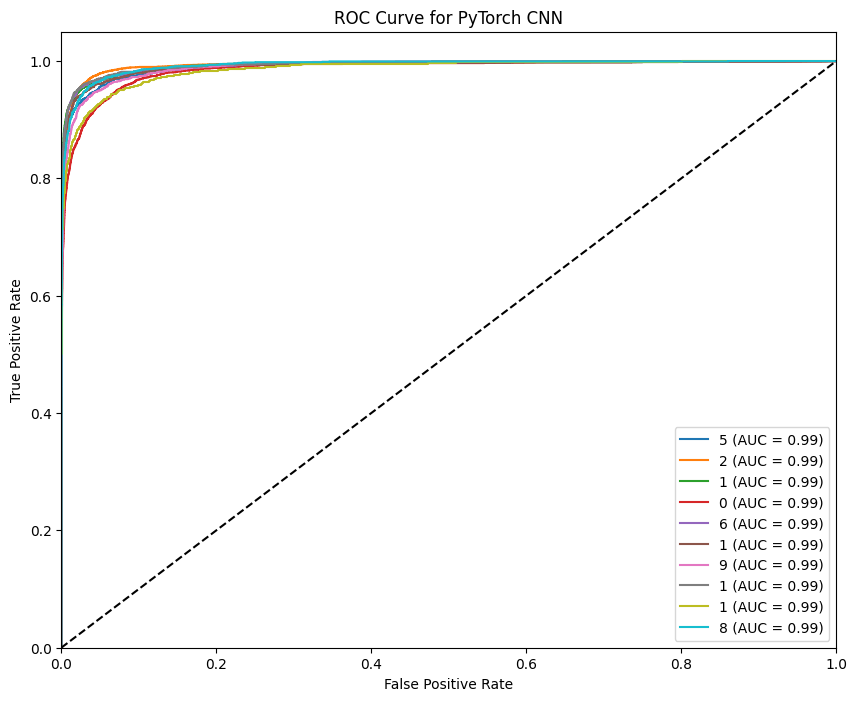


Evaluation Metrics for PyTorch CNN:
Accuracy: 0.8924
Precision (macro): 0.8860
Recall (macro): 0.8850
F1-Score (macro): 0.8843
AUC (macro, OvR): 0.9909


In [66]:
print("\nEvaluating PyTorch CNN Model:")
cnn_metrics = evaluate_model(pytorch_cnn_model, test_loader, "PyTorch CNN")

Memanggil grafik MLP yang sudah di definisikan diatas


Evaluating PyTorch MLP Model:


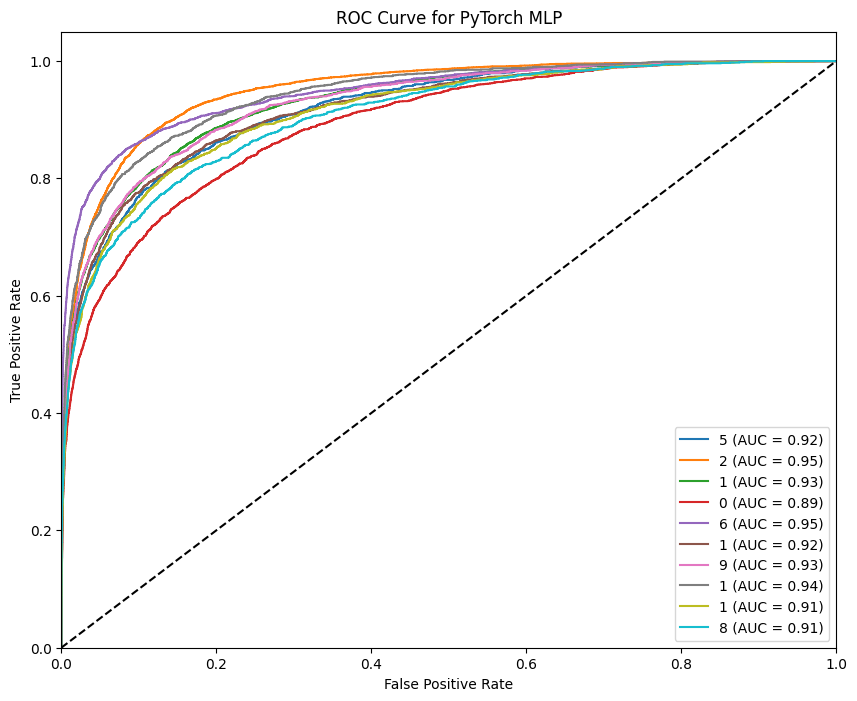


Evaluation Metrics for PyTorch MLP:
Accuracy: 0.6616
Precision (macro): 0.6692
Recall (macro): 0.6263
F1-Score (macro): 0.6365
AUC (macro, OvR): 0.9245


In [67]:
print("\nEvaluating PyTorch MLP Model:")
mlp_metrics = evaluate_model(pytorch_mlp_model, test_loader, "PyTorch MLP")

Perbandingan Akurasi dan Loss antara CNN dengan MLP

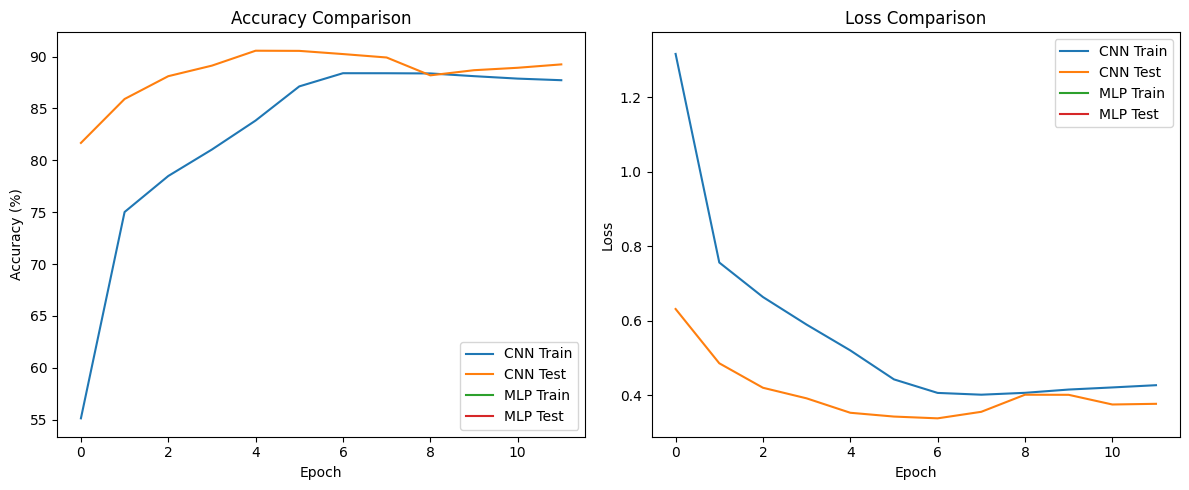

In [68]:
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(pytorch_cnn_train_acc, label='CNN Train')
plt.plot(pytorch_cnn_test_acc, label='CNN Test')
plt.plot(pytorch_mlp_train_acc, label='MLP Train')
plt.plot(pytorch_mlp_test_acc, label='MLP Test')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(pytorch_cnn_train_loss, label='CNN Train')
plt.plot(pytorch_cnn_test_loss, label='CNN Test')
plt.plot(pytorch_mlp_train_loss, label='MLP Train')
plt.plot(pytorch_mlp_test_loss, label='MLP Test')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
print("Perbandingan antara menggunakan CNN dan MLP Vanilla:")
print(f"{'Metric':<15} {'CNN':<10} {'MLP':<10}")
print("-" * 35)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    print(f"{metric:<15} {cnn_metrics[metric]:.4f}     {mlp_metrics[metric]:.4f}")

Perbandingan antara menggunakan CNN dan MLP Vanilla:
Metric          CNN        MLP       
-----------------------------------
accuracy        0.8924     0.6616
precision       0.8860     0.6692
recall          0.8850     0.6263
f1              0.8843     0.6365
auc             0.9909     0.9245


##Tensorflow

###Data Prepatation

In [72]:
#loading dataset dari tensorflow
(data_train, data_test), data_info = tfds.load(
    'svhn_cropped',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.NDH3IV_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.NDH3IV_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.NDH3IV_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


In [73]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [74]:
data_train = data_train.map(preprocess)
data_test = data_test.map(preprocess)

In [75]:
x_train = []
y_train = []
for img, label in tfds.as_numpy(data_train):
    x_train.append(img)
    y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [76]:
x_test = []
y_test = []
for img, label in tfds.as_numpy(data_test):
    x_test.append(img)
    y_test.append(label)
x_test = np.array(x_test)
y_test = np.array(y_test)

###CNN

In [78]:
#callback membuat earlystopping(pengurangan terjadinya overfitting) dan scheduler
callbacks =[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_delta=0.001)
]

Modeling CNN

In [79]:
def cnn():
    weight_decay = 1e-4
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model


Training data dari model cnn diatas

In [80]:
def train_model(model, name, epochs=50):
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=128,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    for epoch in range(len(history.history['accuracy'])):
        train_acc = history.history['accuracy'][epoch] * 100
        test_acc = history.history['val_accuracy'][epoch] * 100
        print(f"Epoch {epoch + 1:>2}/{epochs} {name} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%")


In [81]:
print("\nTraining TensorFlow CNN:")
cnn_model = cnn()
cnn_history = train_model(cnn_model, "TF CNN")


Training TensorFlow CNN:
Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.3002 - loss: 2.5129 - val_accuracy: 0.8362 - val_loss: 0.6871
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7803 - loss: 0.8262 - val_accuracy: 0.8794 - val_loss: 0.5535
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8367 - loss: 0.6817 - val_accuracy: 0.8904 - val_loss: 0.5428
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8602 - loss: 0.6275 - val_accuracy: 0.8976 - val_loss: 0.5258
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8734 - loss: 0.6035 - val_accuracy: 0.9084 - val_loss: 0.5180
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8821 - loss: 0.5871 - val_accuracy: 0.9198 - val_loss: 0.5061
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8890 - loss: 0.5880 - val_accuracy: 0.9082 - val_loss: 0.5610
Epoch 8/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0

###MLP

Pembuatan callback

In [82]:
callbacks =[
     tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,min_delta=0.001,restore_best_weights=True),
     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_delta=0.001)
]

Modeling MLP

In [83]:
def mlp():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

Training model MLP yang sudah di buat diatas

In [84]:
def train_model(model, name, epochs=50):
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=64,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    for epoch in range(len(history.history['accuracy'])):
        train_acc = history.history['accuracy'][epoch] * 100
        test_acc = history.history['val_accuracy'][epoch] * 100
        print(f"Epoch {epoch + 1:>2}/{epochs} {name} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%")


In [85]:
print("Training TensorFlow MLP:")
mlp_model = mlp()
mlp_history = train_model(mlp_model, "TF MLP")

Training TensorFlow MLP:
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2126 - loss: 2.2284 - val_accuracy: 0.4558 - val_loss: 1.6098
Epoch 2/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5095 - loss: 1.4699 - val_accuracy: 0.5640 - val_loss: 1.3794
Epoch 3/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5892 - loss: 1.2613 - val_accuracy: 0.5903 - val_loss: 1.3060
Epoch 4/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6198 - loss: 1.1899 - val_accuracy: 0.5958 - val_loss: 1.2896
Epoch 5/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6340 - loss: 1.1547 - val_accuracy: 0.5890 - val_loss: 1.2925
Epoch 6/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6328 - loss: 1.1437 - val_accuracy: 0.6116 - val_loss: 1.2470
Epoch 7/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6413 - loss: 1.1244 - val_accuracy: 0.6068 - val_loss: 1.2584
Epoch 8/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6432 - loss: 1.1188 - val_accurac

###Evaluasi dari CNN dan MLP

In [88]:
def evaluate_tf_model(model, x_test, y_test, model_name="Model"):
    y_probs = model.predict(x_test)
    y_preds = np.argmax(y_probs, axis=1)

    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds, average='macro')
    rec = recall_score(y_test, y_preds, average='macro')
    f1 = f1_score(y_test, y_preds, average='macro')
    auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro')

    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

    plt.figure(figsize=(10, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
        auc_i = roc_auc_score(y_test == i, y_probs[:, i])
        plt.plot(fpr, tpr, label=f'{all_labels[i]} (AUC = {auc_i:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc
    }


814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Evaluation Metrics for TF MLP:
Accuracy: 0.9198
Precision: 0.9171
Recall: 0.9090
F1 Score: 0.9123
AUC Score: 0.9939


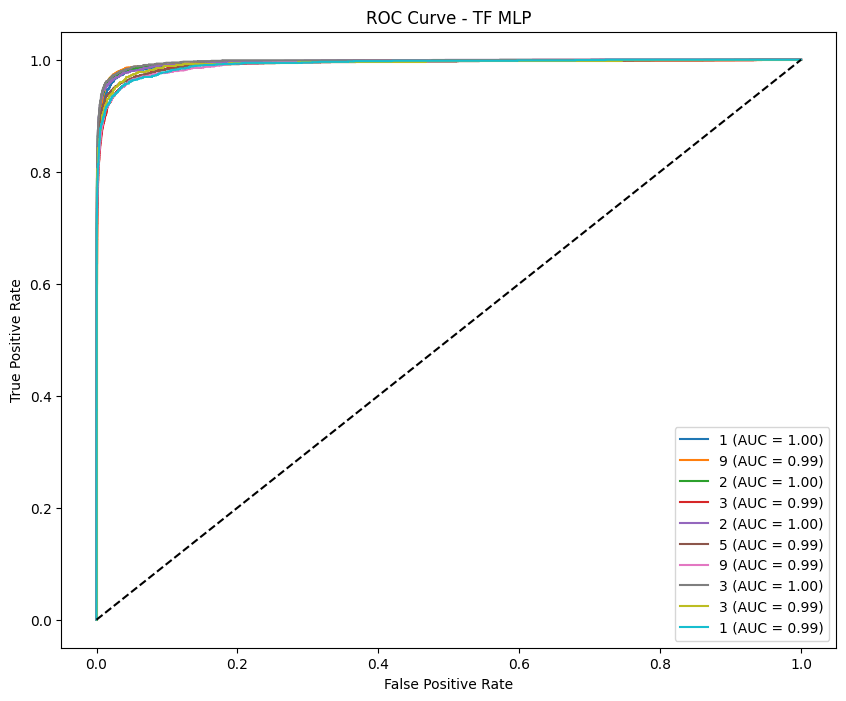

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation Metrics for TF CNN:
Accuracy: 0.6246
Precision: 0.6094
Recall: 0.5828
F1 Score: 0.5909
AUC Score: 0.9076


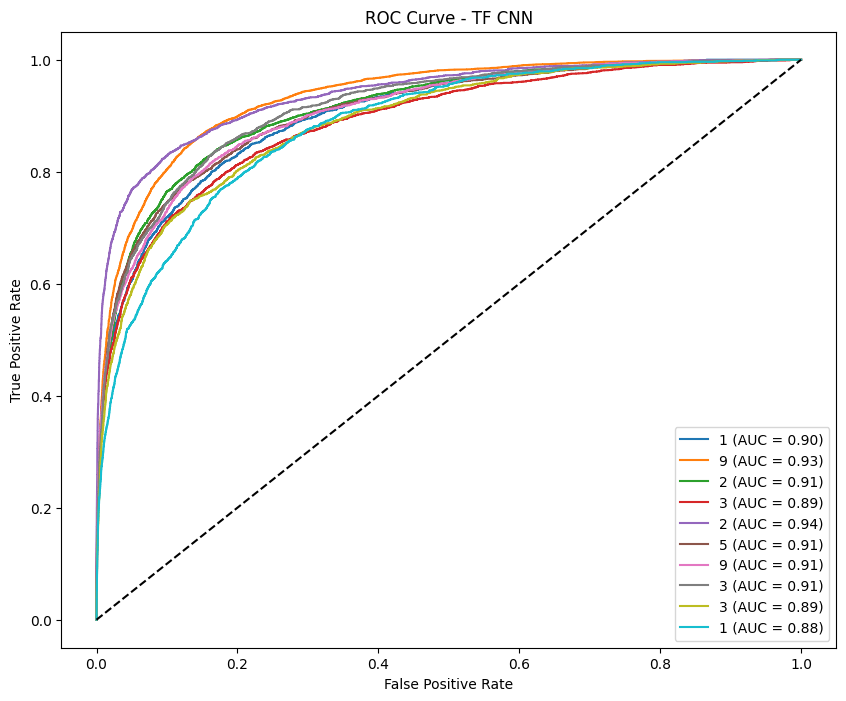

In [89]:
cnn_metrics_tf = evaluate_tf_model(cnn_model, x_test, y_test, "TF MLP")
mlp_metrics_tf = evaluate_tf_model(mlp_model, x_test, y_test, "TF CNN")

In [90]:
print("Pebandingan antara MLP dan CNN")
print(f"{'Metric':<15} {'CNN':<10} {'MLP':<10}")
print("-" * 35)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    print(f"{metric:<15} {cnn_metrics_tf[metric]:.4f}     {mlp_metrics_tf[metric]:.4f}")


Pebandingan antara MLP dan CNN
Metric          CNN        MLP       
-----------------------------------
accuracy        0.9198     0.6246
precision       0.9171     0.6094
recall          0.9090     0.5828
f1              0.9123     0.5909
auc             0.9939     0.9076
